IDS 561 BIG DATA ANALYTICS Final Project

Group members:

ADITYA GAJULA UIN:660252623

RITU GANGWAL UIN:670646774

VIHARIKA BHARTI UIN:655974244

Importing libraries

In [ ]:
import socket
import sys
import requests
import requests_oauthlib
import json
import os
import tweepy as tw
import pandas as pd

Mounting drive on google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing Spark session and setting up enviornment

In [ ]:
# Install JDK
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Install spark
!wget -q http://www.gtlib.gatech.edu/pub/apache/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
# Untar the Spark installer
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz
#Install findspark - a python library to find Spark
!pip install -q findspark

!pip install pyspark

spark-3.0.1-bin-hadoop2.7/
spark-3.0.1-bin-hadoop2.7/RELEASE
spark-3.0.1-bin-hadoop2.7/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/
spark-3.0.1-bin-hadoop2.7/examples/src/main/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/FPGrowthExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/GBTExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/ALSExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/KMeansExample.scala
spark-3.0.1-bin-hadoop2.7/example

In [ ]:
#Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [ ]:
#Creating a local Spark session

import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = SparkContext.getOrCreate() 

In [ ]:
# Import dataset

df = spark.read.csv('/content/drive/Shared drives/IDS 561, Fall 2020/Final Project/Combine these datasets/master_data.csv', inferSchema = True, header = True)
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, TimestampType
df.head(5)

[Row(_c0='0', screen_name=None, tweets='Be sure to tune in and watch Donald Trump on Late Night with David Letterman as he presents the Top Ten List tonight!', created_at='2009-05-04 20:54:25', favourites='868.0', location=None),
 Row(_c0='1', screen_name=None, tweets='Donald Trump will be appearing on The View tomorrow morning to discuss Celebrity Apprentice and his new book Think Like A Champion!', created_at='2009-05-05 03:00:10', favourites='273.0', location=None),
 Row(_c0='2', screen_name=None, tweets='Donald Trump reads Top Ten Financial Tips on Late Show with David Letterman: http://tinyurl.com/ooafwn - Very funny!', created_at='2009-05-08 15:38:08', favourites='18.0', location=None),
 Row(_c0='3', screen_name=None, tweets='New Blog Post: Celebrity Apprentice Finale and Lessons Learned Along the Way: http://tinyurl.com/qlux5e', created_at='2009-05-08 22:40:15', favourites='24.0', location=None),
 Row(_c0='4', screen_name=None, tweets='"""My persona will never be that of a wallf

In [ ]:
# Convert list to dataframe

pandasDF = df.toPandas()
pandasDF= pandasDF.drop(['_c0','screen_name'],axis=1)
pandasDF.head(20)

tweets  ...             location
0   Be sure to tune in and watch Donald Trump on L...  ...                 None
1   Donald Trump will be appearing on The View tom...  ...                 None
2   Donald Trump reads Top Ten Financial Tips on L...  ...                 None
3   New Blog Post: Celebrity Apprentice Finale and...  ...                 None
4   """My persona will never be that of a wallflow...  ...                 None
5   "Miss USA Tara Conner will not be fired - ""I'...  ...                 None
6   Listen to an interview with Donald Trump discu...  ...                 None
7   """Strive for wholeness and keep your sense of...  ...                 None
8   "Enter the ""Think Like A Champion"" signed bo...  ...                 None
9                       """When the achiever achieves  ...  2009-05-17 00:22:45
10  """Don’t be afraid of being unique - it's like...  ...                 None
11  """We win in our lives by having a champion's ...  ...                 None
12  """...these days...we could all use a little o...  ...                 None
13  """Always know you could be on the precipice o...  ...                 None
14  Read a great interview with Donald Trump that ...  ...                 None
15                                    """Keep it fast  ...                 70.0
16  "Don't forget to enter the ""Think Like A Cham...  ...                 None
17  Did you know Donald Trump is on Facebook? http...  ...                 None
18  """Your higher self is in direct opposition to...  ...                 None
19  Read an excerpt from Think Like A Champion by ...  ...                 None

[20 rows x 4 columns]

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'([a-zA-Z]+)') 

def get_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)


def preprocess_comment(input_str):
    comment = str(input_str)
    comment = re.sub("RT @[\w]*:","",comment)
    comment = re.sub("@[\w]*","",comment)
    comment = re.sub("https?://[A-Za-z0-9./]*","",comment)
    comment = re.sub("\n","",comment)
    comment = re.sub(r"(\d{1,3}\.){1,3}\d{1,3}","",comment)  #remove ip's
    words = [word for word in tokenizer.tokenize(comment.lower()) if not word in stop_words]  # convert to lowercase and remove stopwords
    lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word,pos = get_pos(word)) for word in words if len(word)>2]) ## lemmatization of words>2
    return lemmatized_sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
pandasDF['tweets_no_stopwords'] = pandasDF['tweets'].apply(lambda tweet: preprocess_comment(tweet))

In [ ]:
pandasDF.head(20)

tweets  ...                                tweets_no_stopwords
0   Be sure to tune in and watch Donald Trump on L...  ...  sure tune watch donald trump late night david ...
1   Donald Trump will be appearing on The View tom...  ...  donald trump appear view tomorrow morning disc...
2   Donald Trump reads Top Ten Financial Tips on L...  ...  donald trump read top ten financial tip late s...
3   New Blog Post: Celebrity Apprentice Finale and...  ...  new blog post celebrity apprentice finale less...
4   """My persona will never be that of a wallflow...  ...  persona never wallflower rather build wall cli...
5   "Miss USA Tara Conner will not be fired - ""I'...  ...  miss usa tara conner fire always believer seco...
6   Listen to an interview with Donald Trump discu...  ...  listen interview donald trump discuss new book...
7   """Strive for wholeness and keep your sense of...  ...  strive wholeness keep sense wonder intact dona...
8   "Enter the ""Think Like A Champion"" signed bo...  ...  enter think like champion sign book keychain c...
9                       """When the achiever achieves  ...                                  achiever achieves
10  """Don’t be afraid of being unique - it's like...  ...   afraid unique like afraid best self donald trump
11  """We win in our lives by having a champion's ...  ...         win life champion view moment donald trump
12  """...these days...we could all use a little o...  ...  day could use little power trumpative think ba...
13  """Always know you could be on the precipice o...  ...  always know could precipice something great do...
14  Read a great interview with Donald Trump that ...  ...  read great interview donald trump appear new y...
15                                    """Keep it fast  ...                                          keep fast
16  "Don't forget to enter the ""Think Like A Cham...  ...  forget enter think like champion sign book key...
17  Did you know Donald Trump is on Facebook? http...  ...        know donald trump facebook become fan today
18  """Your higher self is in direct opposition to...  ...  high self direct opposition comfort zone donal...
19  Read an excerpt from Think Like A Champion by ...  ...      read excerpt think like champion donald trump

[20 rows x 5 columns]

In [ ]:
#Loading the Bing Lu dictionary - Positive and Negative words files

file1 = open('/content/drive/Shared drives/IDS 561, Fall 2020/Final Project/positive-words.txt', 'r')
positive_binglu = file1.readlines()

file2 = open('/content/drive/Shared drives/IDS 561, Fall 2020/Final Project/negative-words.txt', 'r')
negative_binglu = file2.readlines()

In [ ]:
# formatting the dictionary files to get clean list of positive and negative words

import string
from collections import  Counter
import numpy as np
import regex as re

positive_words = []

for words in positive_binglu[30:]:
  positive_words.append(re.sub(re.compile('\n'), "", words))

negative_words = []

for words in negative_binglu[31:]:
  negative_words.append(re.sub(re.compile('\n'), "", words))

pos = {word:1 for word in positive_words}
neg = {word:-1 for word in negative_words}
pos.update(neg)
sent_dict = pos

def get_sent(input_tweet):
  list_words = input_tweet.split()
  score = 0
  for word in list_words:
    try:
      score+=sent_dict[word]
    except:
      continue
  return score

In [ ]:
pandasDF['binglu_score'] = pandasDF['tweets_no_stopwords'].apply(lambda tweet: get_sent(tweet))
pandasDF['binglu_sentiment'] = np.where(pandasDF['binglu_score']>0,'Positive', (np.where( pandasDF['binglu_score']<0, 'Negative','Neutral')))
pandasDF.head(20)

tweets  ... binglu_sentiment
0   Be sure to tune in and watch Donald Trump on L...  ...         Positive
1   Donald Trump will be appearing on The View tom...  ...         Positive
2   Donald Trump reads Top Ten Financial Tips on L...  ...         Positive
3   New Blog Post: Celebrity Apprentice Finale and...  ...          Neutral
4   """My persona will never be that of a wallflow...  ...         Positive
5   "Miss USA Tara Conner will not be fired - ""I'...  ...          Neutral
6   Listen to an interview with Donald Trump discu...  ...         Positive
7   """Strive for wholeness and keep your sense of...  ...         Positive
8   "Enter the ""Think Like A Champion"" signed bo...  ...         Positive
9                       """When the achiever achieves  ...          Neutral
10  """Don’t be afraid of being unique - it's like...  ...         Positive
11  """We win in our lives by having a champion's ...  ...         Positive
12  """...these days...we could all use a little o...  ...          Neutral
13  """Always know you could be on the precipice o...  ...         Positive
14  Read a great interview with Donald Trump that ...  ...         Positive
15                                    """Keep it fast  ...         Positive
16  "Don't forget to enter the ""Think Like A Cham...  ...         Positive
17  Did you know Donald Trump is on Facebook? http...  ...         Positive
18  """Your higher self is in direct opposition to...  ...         Positive
19  Read an excerpt from Think Like A Champion by ...  ...         Positive

[20 rows x 7 columns]

In [ ]:
from textblob import TextBlob
#Create a function to get the polarity
def getPolarity(text):
  return TextBlob(text).polarity

def getAnalysis(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive'

pandasDF['TextBlob_Score'] = pandasDF['tweets_no_stopwords'].apply(getPolarity)
pandasDF['TextBlob_Sentiment'] = pandasDF['TextBlob_Score'].apply(getAnalysis)
pandasDF.head()

tweets  ... TextBlob_Sentiment
0  Be sure to tune in and watch Donald Trump on L...  ...           Positive
1  Donald Trump will be appearing on The View tom...  ...           Positive
2  Donald Trump reads Top Ten Financial Tips on L...  ...           Positive
3  New Blog Post: Celebrity Apprentice Finale and...  ...           Positive
4  """My persona will never be that of a wallflow...  ...            Neutral

[5 rows x 9 columns]

In [ ]:
#Vader sentiment analysis
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
def getVaderScore(sent):
  return sia.polarity_scores(sent)["compound"]

def getVaderSentiment(score):
    if score >= 0.05:
      return 'Positive'
    elif score <= -0.05:
      return 'Negative'
    else:
      return 'Neutral'

pandasDF['Vader_Score'] = pandasDF['tweets_no_stopwords'].apply(getVaderScore)
pandasDF['Vader_Sentiment'] = pandasDF['Vader_Score'].apply(getVaderSentiment)
pandasDF.head()

     |████████████████████████████████| 133kB 6.6MB/s 


tweets  ... Vader_Sentiment
0  Be sure to tune in and watch Donald Trump on L...  ...        Positive
1  Donald Trump will be appearing on The View tom...  ...        Positive
2  Donald Trump reads Top Ten Financial Tips on L...  ...        Positive
3  New Blog Post: Celebrity Apprentice Finale and...  ...         Neutral
4  """My persona will never be that of a wallflow...  ...         Neutral

[5 rows x 11 columns]

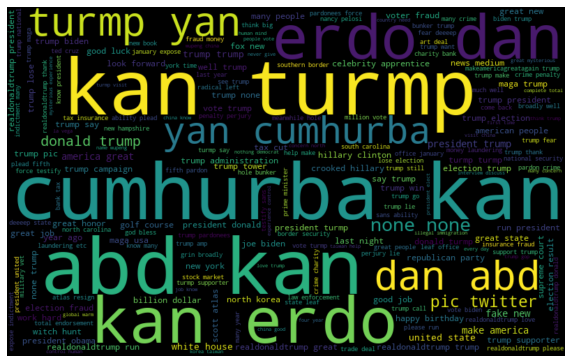

In [ ]:
#Creating word Cloud for Words in tweets
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

Words = ' '.join([text for text in pandasDF['tweets_no_stopwords']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(Words)
plt.figure(figsize=(10, 10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis('off') 
plt.show()

In [ ]:
pandasDF

tweets  ... Vader_Sentiment
0       Be sure to tune in and watch Donald Trump on L...  ...        Positive
1       Donald Trump will be appearing on The View tom...  ...        Positive
2       Donald Trump reads Top Ten Financial Tips on L...  ...        Positive
3       New Blog Post: Celebrity Apprentice Finale and...  ...         Neutral
4       """My persona will never be that of a wallflow...  ...         Neutral
...                                                   ...  ...             ...
931626  @Tam_Resist No, I fully accept Biden won the e...  ...        Negative
931627  @JakeSherman @ABlinken Funny how these stupid,...  ...        Negative
931628  @JohnCornyn “I think, in light of her combativ...  ...        Negative
931629  "@lunaticopresid1 Interesting he says ""shot""...  ...        Positive
931630  @offtom @PepeNewsNow @t23nyw @prayingmedic @LO...  ...        Negative

[931631 rows x 11 columns]

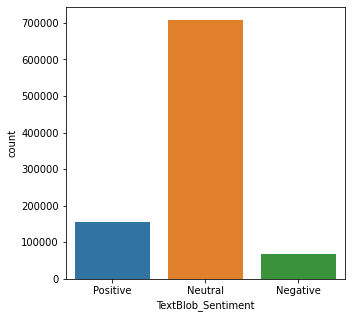

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
ax = sns.countplot(x='TextBlob_Sentiment',data=pandasDF)

In [ ]:
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii',
          'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
          'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New York', 'New Mexico', 'North Carolina',
          'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
          'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']
stateCodes = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
              'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA',
              'WA', 'WV', 'WI', 'WY']
stateMapping = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 
                  'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 
                  'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 
                  'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 
                  'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 
                  'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NY': 'New York', 
                  'NM': 'New Mexico', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 
                  'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 
                  'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT':  'Utah', 'VT': 'Vermont', 
                  'VA': 'Virginia', 'WA': 'Washington', 'WV':  'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}
stateString = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii',
          'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
          'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New York', 'New Mexico', 'North Carolina',
          'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
          'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming','AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN',
              'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA',
              'WA', 'WV', 'WI', 'WY']

In [ ]:
def get_tweet_locations(location_str):
  state_name = "location not available"
  if location_str:
    locationSplit = location_str.split(',')
    for word in locationSplit:
      word_stripped = word.strip()
      if word_stripped in states:
        state_name = word_stripped
      elif word_stripped in stateCodes:
        state_name = stateMapping[word_stripped]
  
  return state_name

In [ ]:
pandasDF['state'] = pandasDF['location'].apply(lambda location: get_tweet_locations(str(location)))
pandasDF

tweets  ...                   state
0       Be sure to tune in and watch Donald Trump on L...  ...  location not available
1       Donald Trump will be appearing on The View tom...  ...  location not available
2       Donald Trump reads Top Ten Financial Tips on L...  ...  location not available
3       New Blog Post: Celebrity Apprentice Finale and...  ...  location not available
4       """My persona will never be that of a wallflow...  ...  location not available
...                                                   ...  ...                     ...
931626  @Tam_Resist No, I fully accept Biden won the e...  ...  location not available
931627  @JakeSherman @ABlinken Funny how these stupid,...  ...                Illinois
931628  @JohnCornyn “I think, in light of her combativ...  ...                  Oregon
931629  "@lunaticopresid1 Interesting he says ""shot""...  ...                  Oregon
931630  @offtom @PepeNewsNow @t23nyw @prayingmedic @LO...  ...  location not available

[931631 rows x 12 columns]

In [ ]:
pandasDF['created_at_year'] = pd.to_datetime(pandasDF['created_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.to_period('Y')
pandasDF

tweets  ... created_at_year
0       Be sure to tune in and watch Donald Trump on L...  ...            2009
1       Donald Trump will be appearing on The View tom...  ...            2009
2       Donald Trump reads Top Ten Financial Tips on L...  ...            2009
3       New Blog Post: Celebrity Apprentice Finale and...  ...            2009
4       """My persona will never be that of a wallflow...  ...            2009
...                                                   ...  ...             ...
931626  @Tam_Resist No, I fully accept Biden won the e...  ...            2020
931627  @JakeSherman @ABlinken Funny how these stupid,...  ...            2020
931628  @JohnCornyn “I think, in light of her combativ...  ...            2020
931629  "@lunaticopresid1 Interesting he says ""shot""...  ...            2020
931630  @offtom @PepeNewsNow @t23nyw @prayingmedic @LO...  ...            2020

[931631 rows x 13 columns]

Text(0.5, 1.0, 'Number of Tweets on Trump')

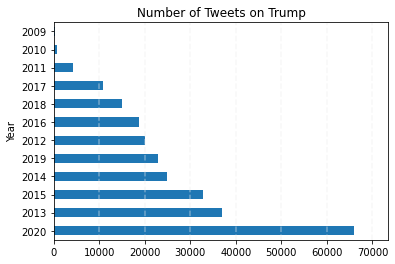

In [ ]:
df = pandasDF['created_at_year'].value_counts()
ax = df.plot(kind='barh')#, figsize=(16, 25), zorder=2)

vals = ax.get_xticks()
for tick in vals:
      ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set y-axis label
ax.set_ylabel("Year")
ax.set_title('Number of Tweets on Trump')

In [ ]:
pandaDF_year2020 = pandasDF.loc[pandasDF['created_at_year'] == '2020']
pandaDF_year2020['month'] = pd.to_datetime(pandaDF_year2020['created_at'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.strftime('%b')
pandaDF_year2020

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


tweets  ... month
40941   Get this straightened out, Governor @ GavinNew...  ...   Jan
40942   Wonderful account of U.S. Embassy (Iraq) vs. t...  ...   Jan
40943   How is the Paris Accord doing? Don’t ask!https...  ...   Jan
40944   One of my greatest honors was to have gotten C...  ...   Jan
40945   Thank you to the @ dcexaminer Washington Exami...  ...   Jan
...                                                   ...  ...   ...
931626  @Tam_Resist No, I fully accept Biden won the e...  ...   Dec
931627  @JakeSherman @ABlinken Funny how these stupid,...  ...   Dec
931628  @JohnCornyn “I think, in light of her combativ...  ...   Dec
931629  "@lunaticopresid1 Interesting he says ""shot""...  ...   Dec
931630  @offtom @PepeNewsNow @t23nyw @prayingmedic @LO...  ...   Dec

[65876 rows x 14 columns]

In [ ]:
def get_sentiments_per_given_column(input_df, column_name, column_list, sentiment_column):
  #tweets_trump_location = input_df.loc[pandasDF['state'] != 'location not available']
  tweets_trump = input_df.groupby([column_name, sentiment_column]).count()
  tweets_trump = tweets_trump['created_at']
  tweets_df = pd.DataFrame({column_name: [column for column in column_list],
                                         'Tweet Positive': [0 for column in column_list],
                                         'Tweet Negative': [0 for column in column_list],
                                         'Tweet Neutral': [0 for column in column_list],
                                         'Tweet Total': [0 for column in column_list]})
  
  tweets_df.set_index(column_name, inplace = True)
  for column in column_list:
    positiveTweet, negativeTweet, neutralTweet = 0, 0, 0
    try:
      positiveTweet = tweets_trump[column]['Positive']
    except:
      positiveTweet = 0
  
    try:
      negativeTweet = tweets_trump[column]['Negative']
    except:
      negativeTweet = 0
  
    try:
      neutralTweet = tweets_trump[column]['Neutral']
    except:
      neutralTweet = 0

    totalTweet = positiveTweet + negativeTweet + neutralTweet

    if totalTweet == 0:
      tweets_df.at[column, 'Tweet Positive'], tweets_df.at[column, 'Tweet Negative'], tweets_df.at[column, 'Tweet Neutral'] = 0,0,0
    else:
      tweets_df.at[column, 'Tweet Positive'] = round((positiveTweet/totalTweet)*100.0)
      tweets_df.at[column, 'Tweet Negative'] = round((negativeTweet/totalTweet)*100.0)
      tweets_df.at[column, 'Tweet Neutral'] = round((neutralTweet/totalTweet)*100.0)

    tweets_df.at[column, 'Tweet Total'] = totalTweet

  return tweets_df

In [ ]:
month_dict = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
pandaDF_2020_month = get_sentiments_per_given_column(pandaDF_year2020, 'month', month_dict, 'TextBlob_Sentiment')
pandaDF_2020_month

Tweet Positive  Tweet Negative  Tweet Neutral  Tweet Total
month                                                            
Jan                49              21             30         1499
Feb                52              23             25         1131
Mar                53              20             27         1278
Apr                48              23             29         1089
May                49              23             28         1641
Jun                55              19             25          957
Jul                 0               0              0            0
Aug                 0               0              0            0
Sep                 0               0              0            0
Oct                 0               0              0            0
Nov                36              27             38        34230
Dec                36              26             37        24051

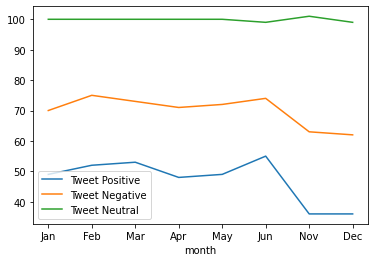

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pandaDF_2020_plot = pandaDF_2020_month.drop('Tweet Total', 1)
pandaDF_2020_plot = pandaDF_2020_plot.drop(['Jul','Aug','Sep','Oct'])
pandaDF_2020_plot.plot(kind='line', stacked=True)

Location wise Results

Text(0.5, 1.0, 'Comparison of Twitter mentions of Trump in all US states as per data collected')

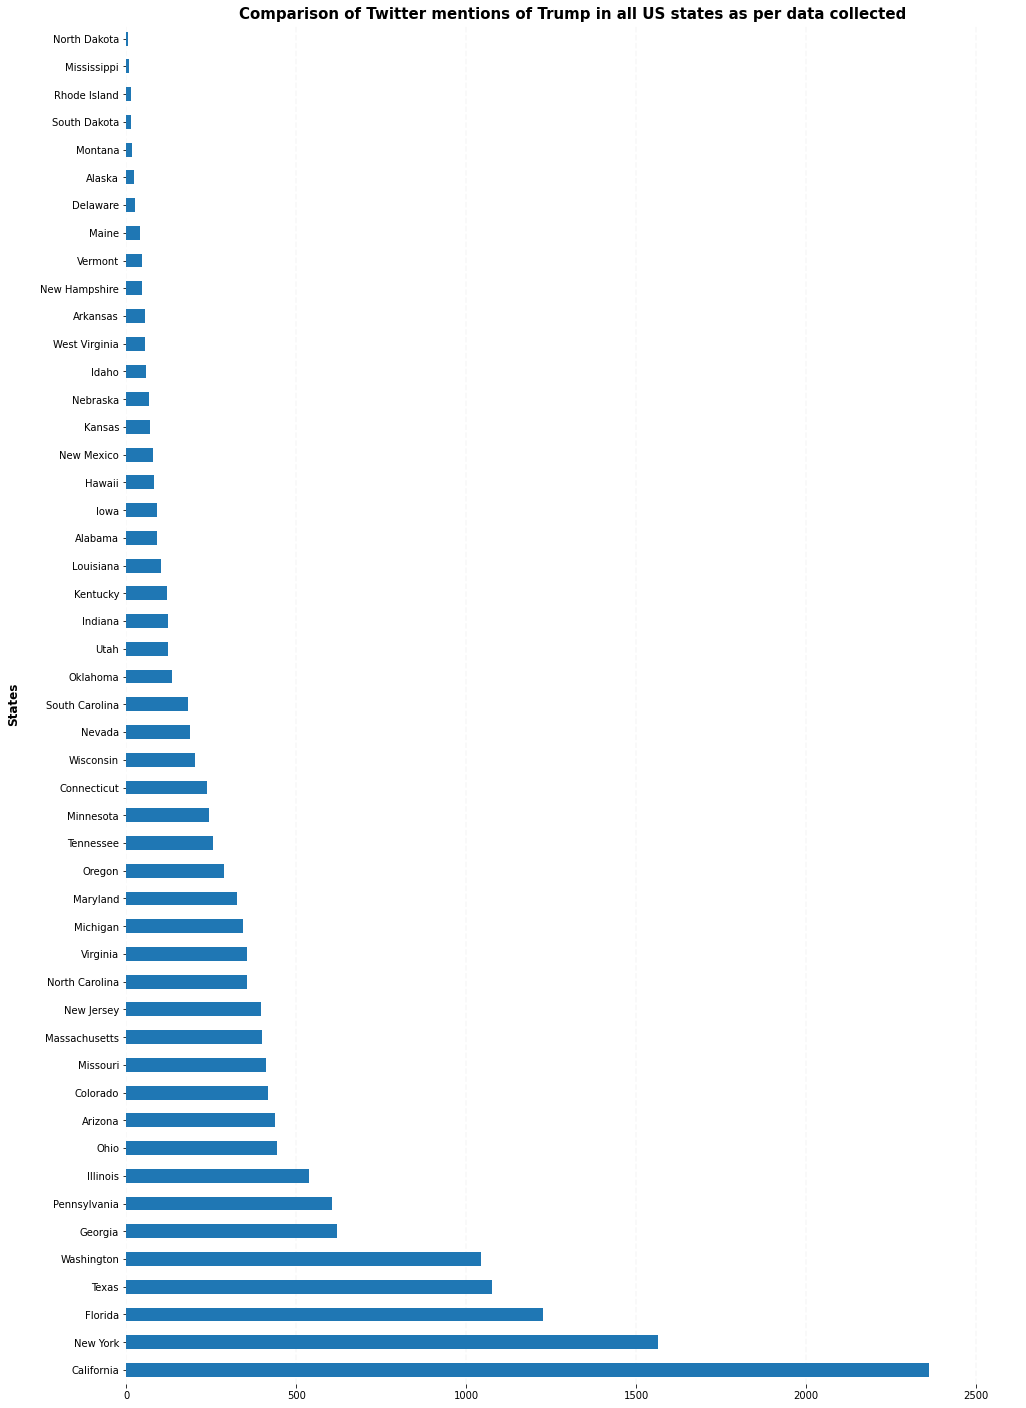

In [ ]:
df = pandasDF.loc[pandasDF['state'] != 'location not available']
df = df['state'].value_counts()
#df = df.rename("state_x": "Total Trump Mentions")
ax = df.plot(kind='barh', figsize=(16, 25), zorder=2)

# Despine
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Replacing ticks with horizontal lines
#ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
vals = ax.get_xticks()
for tick in vals:
      ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

# Set y-axis label
ax.set_ylabel("States", labelpad=20, weight='bold', size=12)
ax.set_title('Comparison of Twitter mentions of Trump in all US states as per data collected',fontweight="bold", size=15)

In [ ]:
#pandasDF_location = get_state_wise_sentiments(pandasDF)
pandaDF_location = pandasDF.loc[pandasDF['state'] != 'location not available']
pandaDF_location_sentiments = get_sentiments_per_given_column(pandaDF_location, 'state', states, 'TextBlob_Sentiment')
pandaDF_location_sentiments

Tweet Positive  Tweet Negative  Tweet Neutral  Tweet Total
state                                                                     
Alabama                     23              33             43           90
Alaska                       0              12             88           24
Arizona                     32              33             35          438
Arkansas                    16              16             68           57
California                  33              23             43         2361
Colorado                    27              27             45          417
Connecticut                 54              15             30          237
Delaware                    56              22             22           27
Florida                     37              29             34         1227
Georgia                     33              24             43          621
Hawaii                      33              19             48           81
Idaho                        5              45             50           60
Illinois                    35              22             44          537
Indiana                     46              24             29          123
Iowa                        50              27             23           90
Kansas                      30              35             35           69
Kentucky                    38              32             30          120
Louisiana                   15              29             56          102
Maine                       14              57             29           42
Maryland                    43              31             26          327
Massachusetts               25              53             22          399
Michigan                    38              23             39          345
Minnesota                   32              33             35          243
Mississippi                  0              67             33            9
Missouri                    17              12             71          411
Montana                     33              50             17           18
Nebraska                    50              14             36           66
Nevada                      38              30             32          189
New Hampshire               69              25              6           48
New Jersey                  28              25             47          396
New York                    33              23             43         1563
New Mexico                  35              27             38           78
North Carolina              37              32             31          357
North Dakota               100               0              0            6
Ohio                        32              29             39          444
Oklahoma                    51              20             29          135
Oregon                      38              22             41          288
Pennsylvania                33              32             35          606
Rhode Island                20              20             60           15
South Carolina              30              26             44          183
South Dakota                20              40             40           15
Tennessee                   52              22             26          255
Texas                       33              27             40         1077
Utah                        39              39             22          123
Vermont                     38              50             12           48
Virginia                    31              24             45          357
Washington                  36              26             39         1044
West Virginia               32              16             53           57
Wisconsin                   26              41             32          204
Wyoming                      0               0              0            0

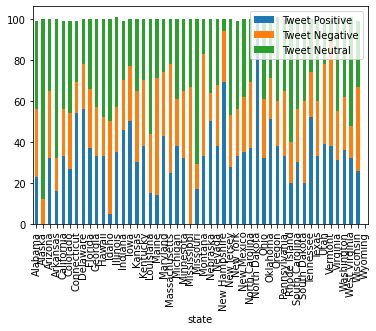

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pandaDF_location_plot = pandaDF_location_sentiments.drop('Tweet Total', 1)
pandaDF_location_plot.plot(kind='bar', stacked=True)
#pandaDF_location_plot.plot(kind='bar', linewidth=3)

In [ ]:
def get_predicted_judgement(input_df):
  input_df['Predicted Judgement'] = 'Neutral'
  for index, row in input_df.iterrows():
    if row['Tweet Total'] <= 15:
      input_df.loc[index, 'Predicted Judgement'] = 'Insufficient Data'
    else:
      if row['Tweet Positive'] >= 33:
        input_df.loc[index, 'Predicted Judgement'] = 'Republican'
      else:
        input_df.loc[index, 'Predicted Judgement'] = 'Democratic'
  input_df = input_df.rename(columns={'Tweet Positive': 'Tweet Positive (in %)', 
                                                        'Tweet Negative': 'Tweet Negative (in %)',
                                                        'Tweet Neutral': 'Tweet Neutral (in %)',
                                                        'Tweet Total': 'Tweet Total Mentions'})
  return input_df

In [ ]:
pandasDF_prediction = get_predicted_judgement(pandaDF_location_sentiments)

In [ ]:
pandasDF_prediction.groupby('Predicted Judgement').size()

Predicted Judgement
Democratic           18
Insufficient Data     5
Republican           27
dtype: int64